# Identify CpGs influencing PaCMAP components

```{contents}
```

## Canonical Correlation Analysis (CCA)

- __CCA__: Canonical Correlation Analysis

- __Scikit-Learn API__: [Code Reference](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.CCA.html), [User Guide](https://scikit-learn.org/stable/modules/cross_decomposition.html#id5)

- __Reference__: [A survey of Partial Least Squares (PLS) methods, with emphasis on the two-block case](https://stat.uw.edu/sites/default/files/files/reports/2000/tr371.pdf)

## Load data

In [1]:
import pandas as pd
from source.pacmap_functions import *

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'

# read df_discovery and df_validation
df_discovery = pd.read_pickle(
    input_path+'df_discovery.pkl').sort_index()

df_validation = pd.read_pickle(
    input_path+'df_validation.pkl').sort_index()

# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

# Load clinical data
validation_clinical_data = pd.read_csv(input_path+'validation_clinical_data.csv',
                                        low_memory=False, index_col=0)

# Adjust clinical data
discovery_clinical_data['Train Test'] = 'Discovery (train) Samples'
validation_clinical_data['Train Test'] = 'Validation (test) Samples'

discovery_clinical_data['PaCMAP Output'] = 'Patient Samples'
validation_clinical_data['PaCMAP Output'] = 'Patient Samples'

discovery_clinical_data['Batch'] = df_discovery['Batch']
validation_clinical_data['Batch'] = 'St Jude Children\'s'

# use overlapping features between df_discovery and df_validation
common_features = [x for x in df_discovery.columns if x in df_validation.columns]

# apply `common_features` to both df_discovery and df_validation
df_discovery = df_discovery[common_features]
df_validation = df_validation[common_features]

print(
f' Discovery dataset (df_discovery) contains {df_discovery.shape[1]} \
columns (5mC nucleotides/probes) and {df_discovery.shape[0]} rows (samples).')

print(
f' Validation dataset (df_validation) contains {df_validation.shape[1]} \
columns (5mC nucleotides/probes) and {df_validation.shape[0]} rows (samples).')

from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=1)

pacmap_components = df[df['Train Test'] == 'Discovery (train) Samples'][['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']]

df_discovery = df_discovery[df_discovery.index.isin(pacmap_components.index)]

df_discovery.shape, pacmap_components.shape # ((3059, 319738), (3059, 5))


 Discovery dataset (df_discovery) contains 319738 columns (5mC nucleotides/probes) and 3330 rows (samples).
 Validation dataset (df_validation) contains 319738 columns (5mC nucleotides/probes) and 201 rows (samples).


((3059, 319738), (3059, 5))

## Run CCA

In [2]:

# Let's perform CCA between the scaled high-dimensional data and the PaCMAP components
X = df_discovery
Y = pacmap_components.values  # convert dataframe to numpy array

# Create a CCA object
cca = CCA(n_components=5)  # we are considering all 5 PaCMAP components

# Fit the CCA model
cca.fit(X, Y)

# Save the CCA model
import pickle
with open(output_path+'pacmap_output/CCA_model.pkl', 'wb') as f:
    pickle.dump(cca, f)

# Apply the dimensionality reduction on X and Y
X_c, Y_c = cca.transform(X, Y)

# convert numpy arrays to pandas DataFrame
df_X_c = pd.DataFrame(X_c, columns=['CCA Component 1', 'CCA Component 2', 'CCA Component 3', 'CCA Component 4', 'CCA Component 5'], index=df_discovery.index)
df_Y_c = pd.DataFrame(Y_c, columns=pacmap_components.columns, index=pacmap_components.index)

# save dataframes to csv files
df_X_c.to_csv(output_path+'pacmap_output/X_c_CCA_analysis.csv')
df_Y_c.to_csv(output_path+'pacmap_output/Y_c_CCA_analysis.csv')

# read dataframes from csv files
df_X_c = pd.read_csv(output_path+'pacmap_output/X_c_CCA_analysis.csv', index_col=0)
df_Y_c = pd.read_csv(output_path+'pacmap_output/Y_c_CCA_analysis.csv', index_col=0)

# read CCA model
with open(output_path+'pacmap_output/CCA_model.pkl', 'rb') as f:
    cca = pickle.load(f)


## Results

### X loadings correlations

In [25]:
# Get the loadings
x_loadings = cca.x_loadings_
y_loadings = cca.y_loadings_

# Convert the loadings to dataframes for easier handling
df_x_loadings = pd.DataFrame(x_loadings, columns=df_X_c.columns, index=df_discovery.columns)
df_y_loadings = pd.DataFrame(y_loadings, columns=df_Y_c.columns, index=pacmap_components.columns)

df_x_loadings.describe().round(3)

,CCA Component 1,CCA Component 2,CCA Component 3,CCA Component 4,CCA Component 5
count,319738.000,319738.000,319738.000,319738.000,319738.000
mean,-0.011,0.003,0.001,-0.000,0.000
std,0.014,0.009,0.010,0.013,0.009
min,-0.063,-0.040,-0.054,-0.069,-0.055
25%,-0.019,-0.003,-0.003,-0.006,-0.004
50%,-0.008,0.000,0.001,0.001,-0.001
75%,-0.002,0.007,0.005,0.008,0.004
max,0.039,0.045,0.059,0.060,0.067


### Max contributing variables for X components

In [26]:
# Find the variable that contributes the most to each component
max_contrib_x = df_x_loadings.idxmax()

max_contrib_x

CCA Component 1    cg05184729
CCA Component 2    cg10142874
CCA Component 3    cg05215277
CCA Component 4    cg19368911
CCA Component 5    cg18349022
dtype: object

### Plots

The scatter plots will show you how each pair of canonical variables is related, with the correlation coefficient displayed in the title. Points that are close together represent observations that have similar values for both sets of variables, after the CCA transformation.

The heatmaps will show you the loadings of each variable for each component, with red values indicating a high positive contribution, blue values indicating a high negative contribution, and values near zero indicating little or no contribution.

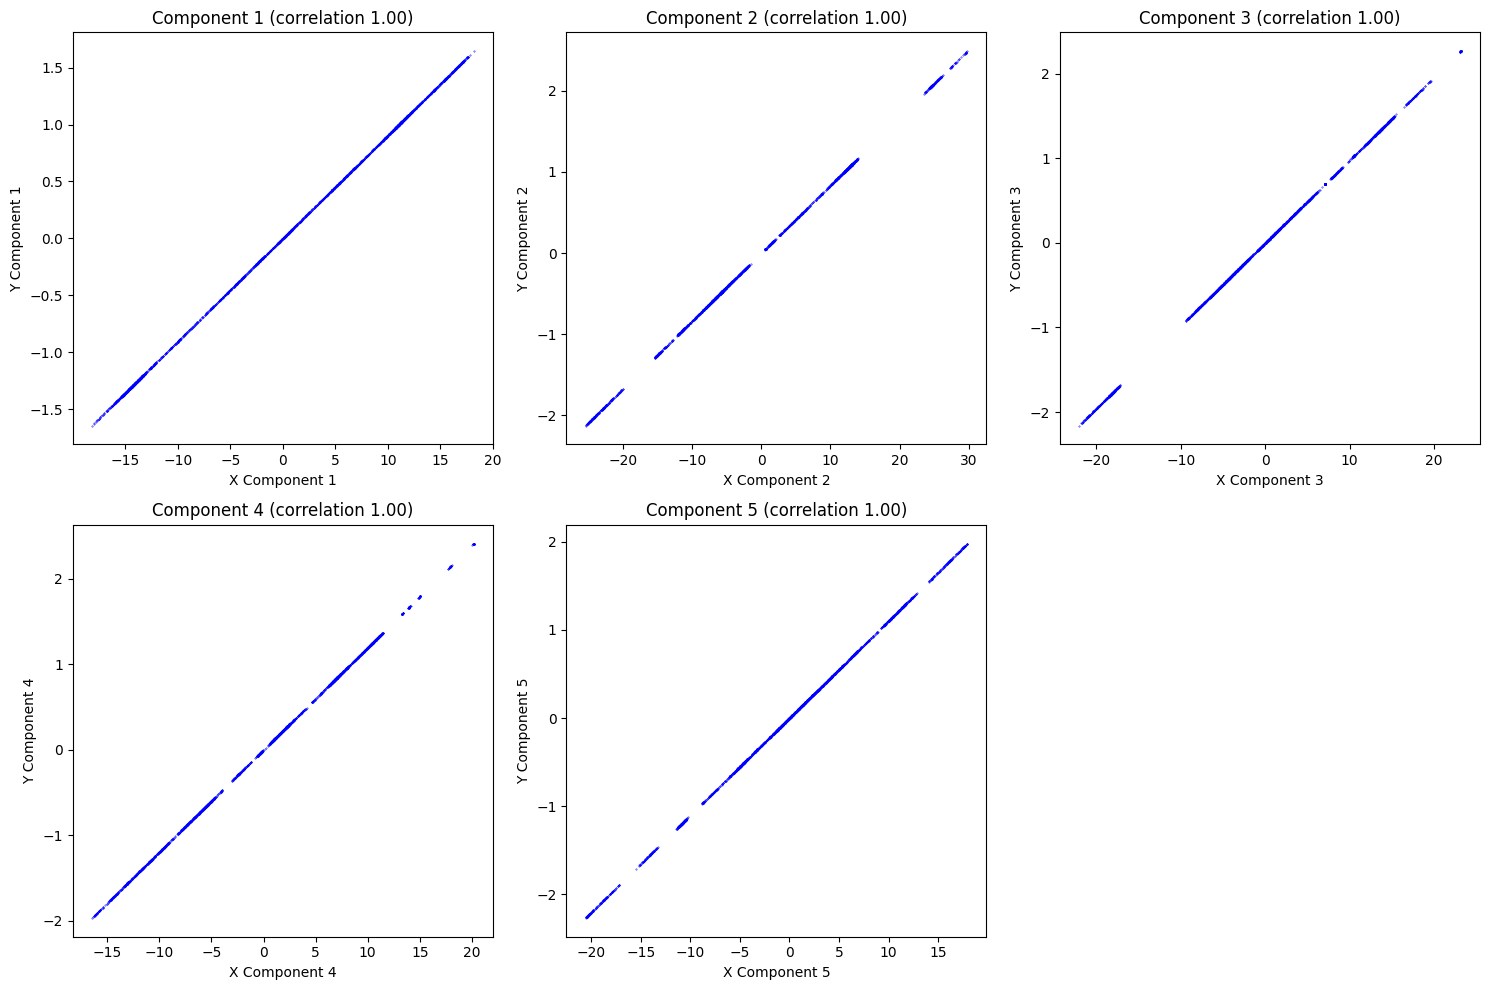

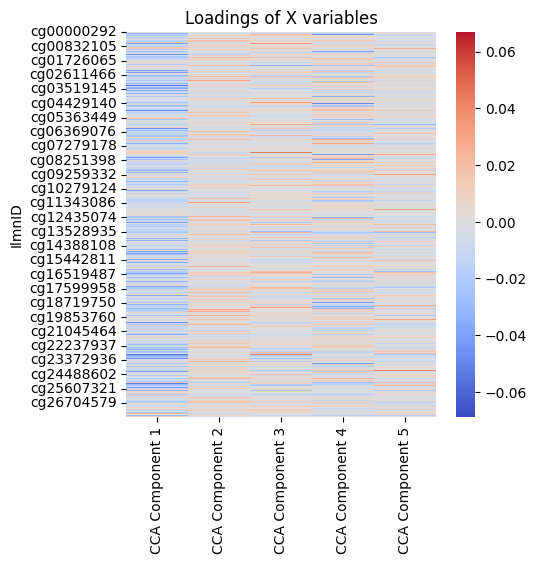

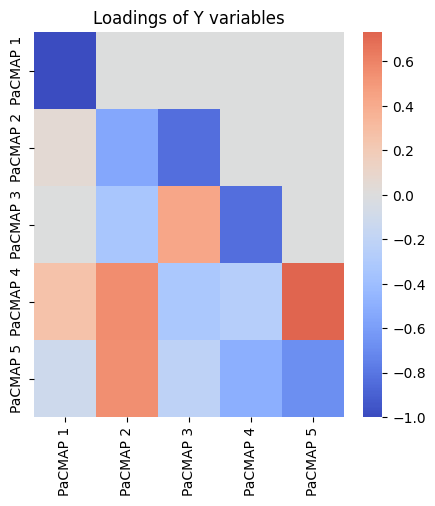

In [28]:
import seaborn as sns

# 1. Scatter plot of the canonical variables
plt.figure(figsize=(15, 10))

for i in range(df_X_c.shape[1]):
    plt.subplot(2, 3, i+1)  # assuming you have 5 components
    plt.scatter(df_X_c.iloc[:, i], df_Y_c.iloc[:, i], c='b', s=0.1)
    plt.xlabel('X Component {}'.format(i+1))
    plt.ylabel('Y Component {}'.format(i+1))
    plt.title('Component {} (correlation {:.2f})'.format(i+1, np.corrcoef(df_X_c.iloc[:, i], df_Y_c.iloc[:, i])[0, 1]))

plt.tight_layout()
plt.show()

# 2. Heatmap of the loadings
plt.figure(figsize=(5, 5))
sns.heatmap(df_x_loadings, cmap='coolwarm', center=0)
plt.title('Loadings of X variables')
plt.show()

plt.figure(figsize=(5, 5))
sns.heatmap(df_y_loadings, cmap='coolwarm', center=0)
plt.title('Loadings of Y variables')
plt.show()


## How it works

CCA is a multivariate statistical method that is used to understand the relationships between two sets of variables or multi-dimensional data. The method investigates the possible correlations between linear combinations of variables in two data sets.

**How does it work?**

CCA constructs a pair of linear combinations, one for each data set, such that the correlation between these two linear combinations (canonical variables or canonical scores) is maximized. 

In mathematical terms, suppose we have two data sets X and Y, where X is an n x p matrix and Y is an n x q matrix. CCA seeks to find vectors a and b such that the correlation between Xa and Yb is maximized. The vectors a and b are known as canonical weights, and the correlation between Xa and Yb is called the canonical correlation. 

The procedure is repeated to find additional pairs of canonical variables that are uncorrelated with the previously obtained pairs, up to min(p, q) pairs can be found. The analysis provides canonical correlation coefficients, canonical weights, and loadings (the correlation between the variables and their respective canonical variables) for each pair.

**Interpreting the results of CCA:**

The results of CCA can provide insights about the relationships between the two sets of variables. Here's how you can interpret these results:

1. **Canonical Correlations**: These are the correlations between the pairs of canonical variables. These correlations can be used to determine the strength and significance of the relationship between the two sets of variables. The larger the canonical correlation, the stronger the relationship between the linear combinations of variables.

2. **Canonical Weights**: These weights show the contribution of each variable to the canonical variable. They can help to identify the variables that contribute the most to the relationship between the two sets of variables.

3. **Canonical Loadings**: These are the correlations between the original variables and the canonical variables. The loadings can give additional insights about the relationships between the variables.

4. **Canonical Cross-loadings**: These are the correlations between the variables from one set and the canonical variable from the other set. They can provide insights about the relationships between the variables across the two sets.

5. **Redundancy Analysis**: It measures the amount of variance shared between the data sets. It is used to assess how much information from one set can be inferred from the other set.

The number of significant canonical correlations (often determined using a statistical test like Wilks' Lambda) indicates the number of meaningful dimensions that connect the two data sets.

__For df_X_c:__ 
    
The five components here are the canonical components derived from your high-dimensional data (df_discovery). Each component is a weighted sum of the original variables (columns in df_discovery), such that the resulting components are uncorrelated with each other, and the correlation between each corresponding pair of components from X_c and Y_c is maximized. These components represent new variables that provide a way to understand the association between the two datasets.

__For df_Y_c:__ 

These components are the canonical components derived from the PaCMAP components. Each of these is a weighted sum of the five PaCMAP variables, again ensuring uncorrelation between these components and maximizing correlation with the corresponding components from df_X_c.

The order of the components is important. The first pair of canonical components (first component from X_c and first from Y_c) is the pair that has the maximum possible correlation. The second pair has the maximum possible correlation out of all pairs that are uncorrelated with the first pair, and so on.

Please note that while CCA helps uncover relationships between two sets of variables, interpreting the components is not always straightforward. Each component is a combination of all the original variables, and the coefficients (or weights) can be examined to see which original variables are contributing the most to each component. However, these weights can sometimes be difficult to interpret, especially if the original variables are not easily interpretable to begin with, or if there are a large number of them.

## Watermark

In [32]:
%load_ext watermark

In [34]:
%watermark -v -p numpy,scipy,matplotlib,sklearn,pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

numpy     : 1.24.3
scipy     : 1.10.1
matplotlib: 3.7.1
sklearn   : 1.2.2
pandas    : 2.0.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

